## Import required packages 

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARMA
from matplotlib.pylab import rcParams
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from matplotlib.pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

## Import data from AWS and prepare for processing

In [2]:
df = pd.read_csv('https://mod4finalproject.s3.amazonaws.com/zillow_cleaned_no_nulls.csv',
                   index_col=0,
                   dtype = {'zip':'object'})

In [3]:
df.index = pd.to_datetime(df.index)

In [138]:
df_1718 = df.loc[(df.index >= '2017-01-01') & (df.index <= '2018-01-01')]
df_1718 = df_1718.groupby(df_1718.index).mean()
np.log(df_1718.value[-1]) - np.log(df_1718.value[0])

0.06027699175452028

In [5]:
df = df.drop(columns = ['regionid', 'city', 'state', 'metro', 'countyname', 'sizerank'])

In [6]:
d2011 = '2011-05-01'
d2018 = '2018-04-01'

In [7]:
df = df[d2011:d2018]

## Define top 5 zip codes

In [8]:
top_zips = ['33976', '33974', '47353', '71263', '67860']

In [9]:
df = df.loc[df.zip.isin(top_zips)]

## Define functions for use in analysis

In [10]:
def plot_zip(df,zipcode, start, end):
    zip_df = df.loc[df['zip']==zipcode]
    zip_df = zip_df.loc[(zip_df.index >= start) & (zip_df.index <= end)]
    sns.set(rc={'figure.figsize':(15,5)}, style='darkgrid')
    sns.lineplot(x=zip_df.index, y=zip_df.value)
    return plt.show()

In [11]:
def plot_diff(df, zipcode, start, end, lag):
    zip_df = df.loc[df['zip'] == zipcode]
    zip_df = zip_df.loc[(zip_df.index >= start) & (zip_df.index <= end)] 
    zip_df['diff'] = zip_df.value - zip_df.value.shift(lag)
    sns.set(rc={'figure.figsize':(15,5)}, style='darkgrid')
    plot = sns.lineplot(x=zip_df.index, y=zip_df['diff'])
    return plt.show()

In [12]:
def get_zip_df(df, zipcode, start, end):
    zip_df = df.loc[df['zip']==zipcode]
    zip_df = zip_df.loc[(zip_df.index >= start) & (zip_df.index <= end)]
    return zip_df

In [13]:
def get_diff_df(df, zipcode, start, end, lag):
    diff_df = df.loc[df['zip'] == zipcode]
    diff_df = diff_df.loc[(diff_df.index >= start) & (diff_df.index <= end)] 
    diff_df['diff'] = diff_df.value - diff_df.value.shift(lag)
    diff_df = diff_df.dropna(axis=0)
    return diff_df

In [14]:
## Test functions
# diff_df(df, top_zips[0], d2011, d2018, 2)

In [15]:
## Test functions
# for z in top_zips:
#     diff_plot(df, z, d2011, d2018, 1)

## Analysis for Lakin, KS 67860

In [102]:
zipcode = '67860'
start = d2011
end = d2018
lag = 1

lakin = get_zip_df(df, zipcode, start, end)

### Plot of values, monthly

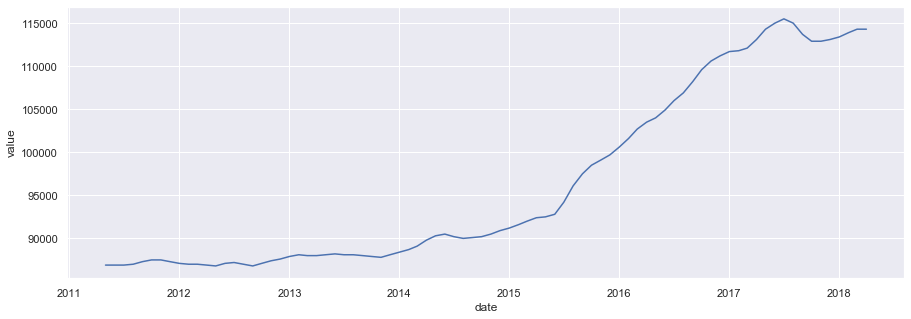

In [51]:
plot_zip(df, zipcode, start, end)

### Decomposition

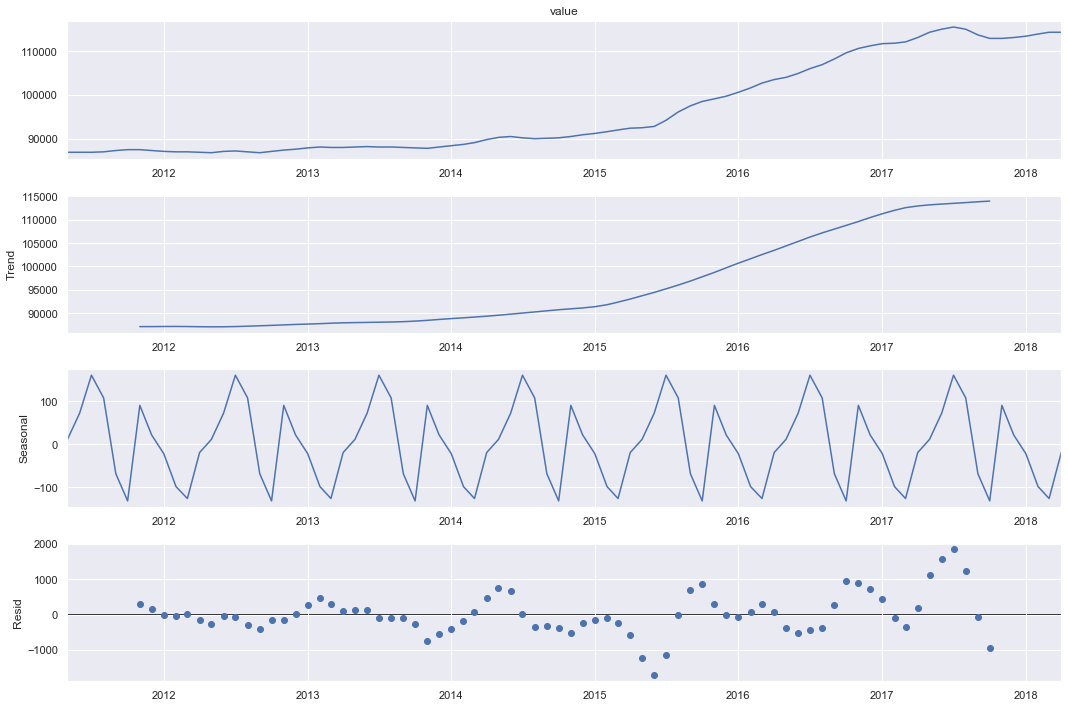

In [52]:
rcParams['figure.figsize'] = (15, 10)
result = seasonal_decompose(lehigh.value, model='additive')
result.plot()
plt.show()

### Plot of difference from lag

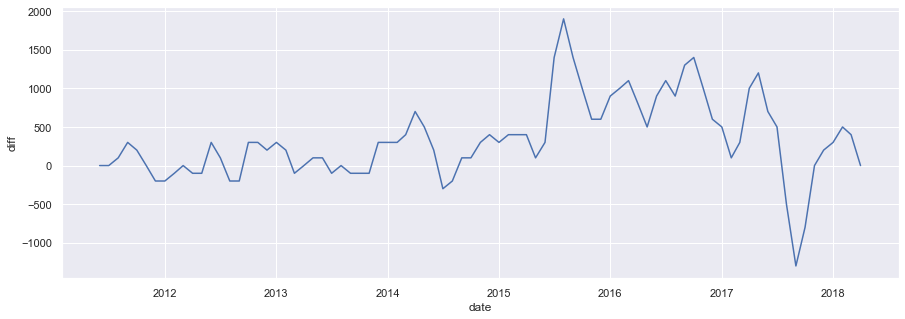

In [53]:
plot_diff(df, zipcode, start, end, lag)

### ACF and PACF for lag values

In [54]:
diff_df = get_diff_df(df, zipcode, start, end, lag)

### ACF (Pandas)

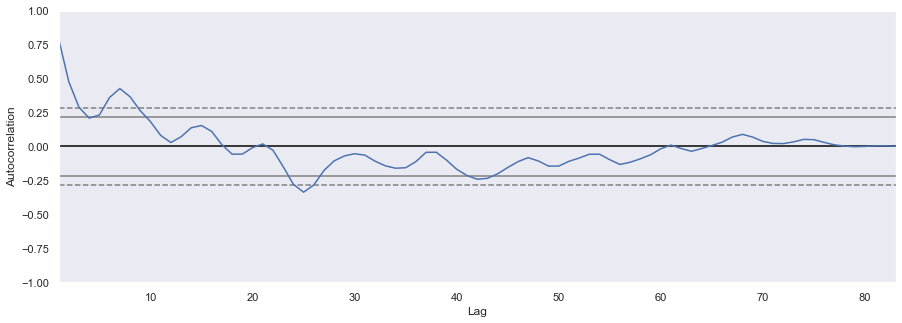

In [55]:
plt.figure(figsize=(15,5))
pd.plotting.autocorrelation_plot(diff_df['diff']);

### ACF (statsmodel)

In [56]:
# diff_df['diff']

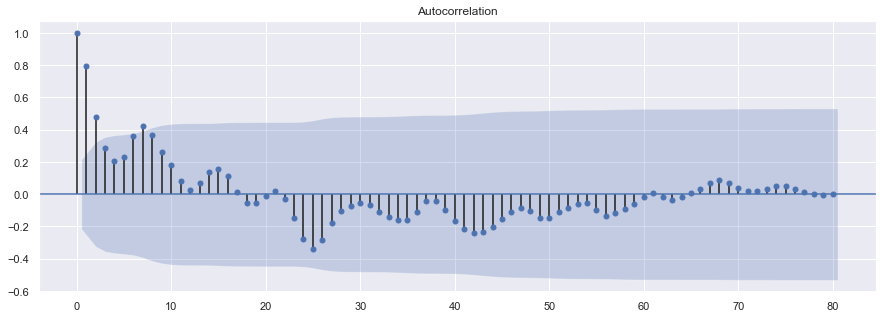

In [57]:
rcParams['figure.figsize'] = 15, 5
plot_acf(diff_df['diff'], lags=80);

### PACF (statsmodel)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


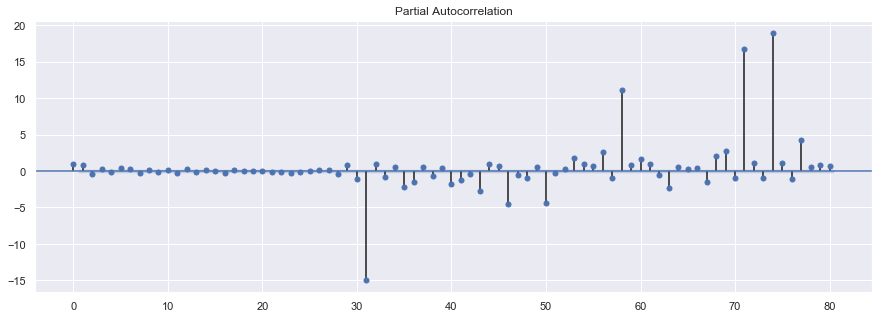

In [58]:
rcParams['figure.figsize'] = 15, 5
plot_pacf(diff_df['diff'], lags=80);

In [93]:
import pickle
pickle_in = open('../data/processed/train_val_test.pickle', 'rb')
train_val_test = pickle.load(pickle_in)

train = train_val_test[0]
val = train_val_test[1]
test = train_val_test[2]

In [94]:
train = train.loc[train.zip == zipcode]
val = val.loc[val.zip == zipcode]
test = test.loc[test.zip == zipcode]

In [97]:
train = pd.concat([train, val])

In [83]:
model = ARIMA(np.asarray(train.value), order=(3,2,1))
model_fit = model.fit(disp=0)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                   D2.y   No. Observations:                   58
Model:                 ARIMA(3, 2, 1)   Log Likelihood                -393.536
Method:                       css-mle   S.D. of innovations            208.124
Date:                Thu, 07 May 2020   AIC                            799.071
Time:                        20:54:19   BIC                            811.434
Sample:                             2   HQIC                           803.887
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.9422      4.507      3.537      0.000       7.108      24.776
ar.L1.D2.y     1.1366      0.130      8.735      0.000       0.882       1.392
ar.L2.D2.y    -0.7137      0.172     -4.147      0.000      -1.051      -0.376
ar.L3.D2.y     0.2460      0.130      1.899      0.057      -0.008       0.500
ma.L1.D2.y    -1.0000      0.069    -14.474      0.000      -1.135      -0.865
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.6010           -0.0000j            1.6010           -0.0000
AR.2            0.6500           -1.4548j            1.5934           -0.1831
AR.3            0.6500           +1.4548j            1.5934            0.1831
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

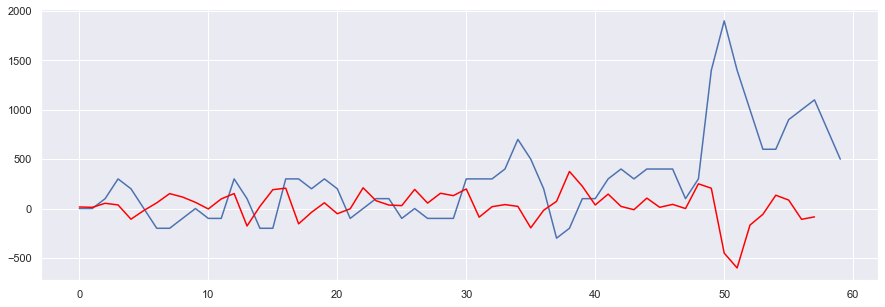

In [63]:
plt.plot(np.array(diff_df['diff'])[0:60])
plt.plot(model_fit.fittedvalues, color='red')
plt.show()

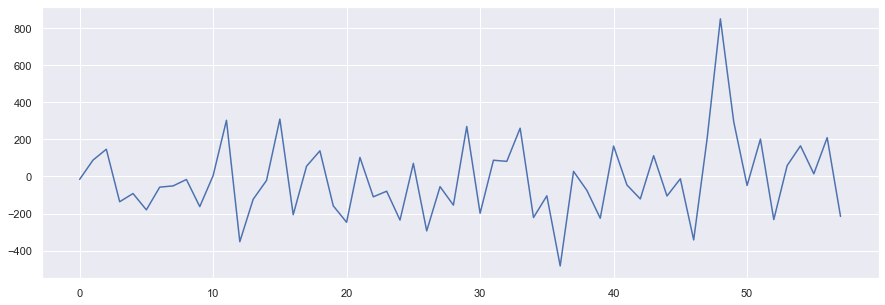

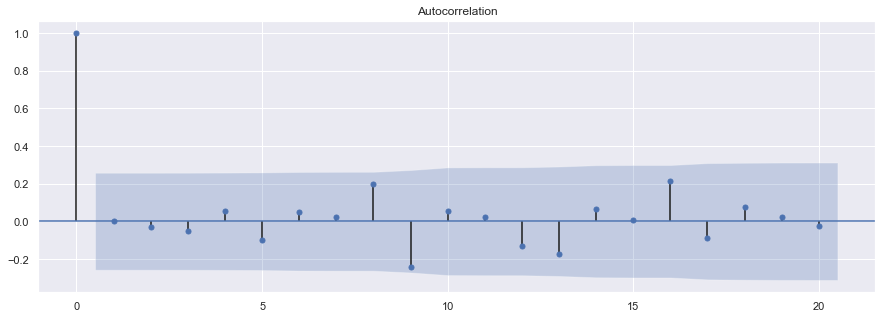

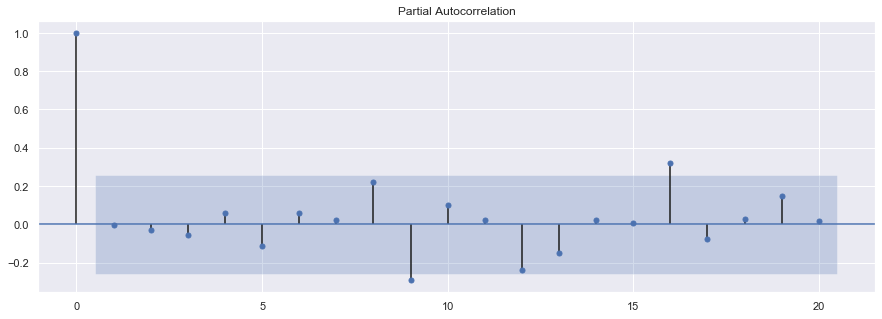

In [64]:
resid = model_fit.resid
plt.plot(resid)
plt.show()
rcParams['figure.figsize'] = 15, 5
plot_acf(resid, lags=20)
plt.show()
plot_pacf(resid, lags=20)
plt.show()

In [65]:
pred = model_fit.forecast(steps=24)
test_pred = pred[0]

RMSE for Test Period: 5282.099353761133


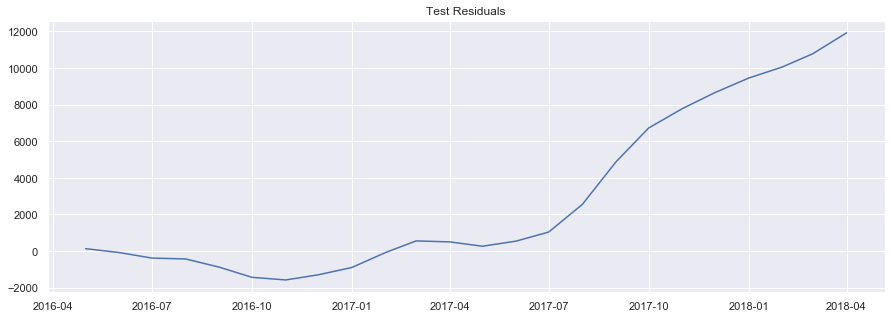

In [66]:
test_resid = test_pred - test.value
rmse = np.sqrt(mean_squared_error(test.value, test_pred))
print('RMSE for Test Period: {}'.format(rmse))
plt.plot(test_resid)
plt.title('Test Residuals')
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


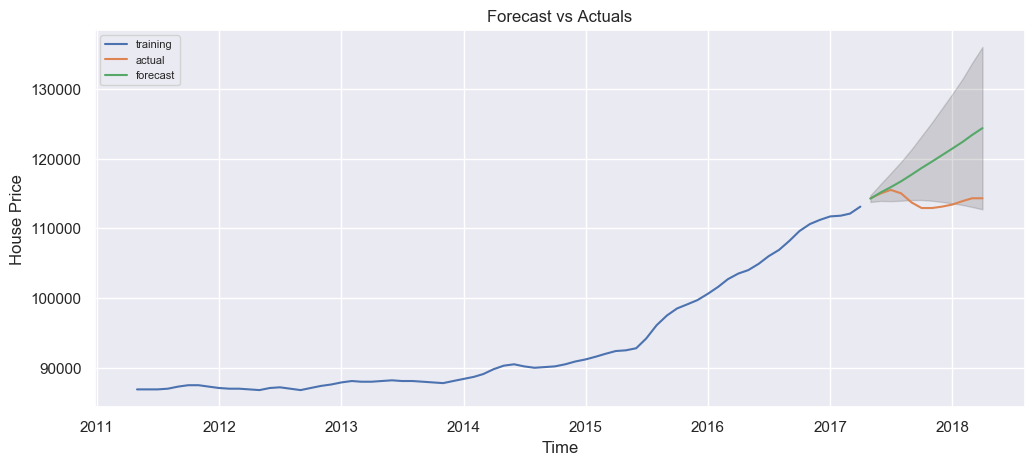

In [125]:
model = ARIMA(train['value'], order=(3, 2, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(12, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train['value'], label='training')
plt.plot(test['value'], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.xlabel('Time')
plt.ylabel('House Price')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.savefig('/Users/josephmchugh/Pictures/Mod4_Plots/lakin_forecast_test.png')
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


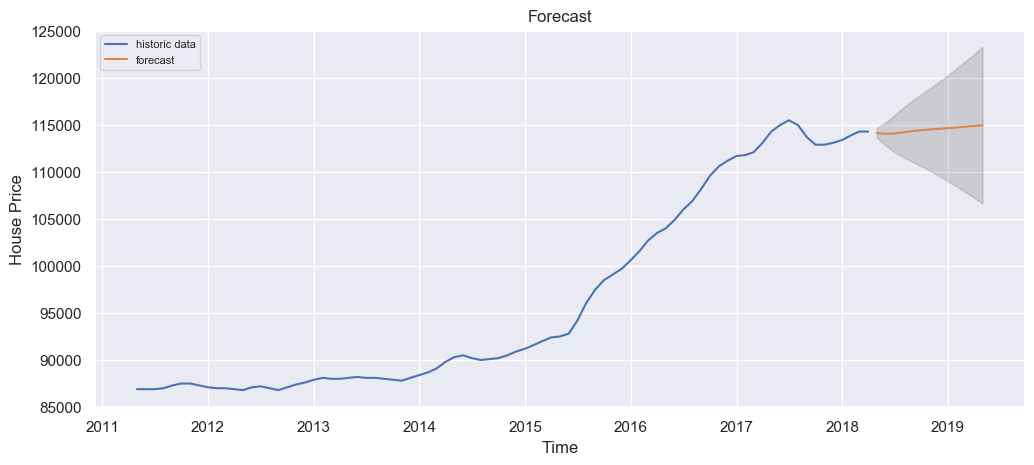

In [124]:
model = ARIMA(lakin['value'], order=(3, 2, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(12, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=pd.date_range('2018-05-01', '2019-05-01',12))
lower_series = pd.Series(conf[:, 0],index=pd.date_range('2018-05-01', '2019-05-01',12))
upper_series = pd.Series(conf[:, 1],index=pd.date_range('2018-05-01', '2019-05-01',12))

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(lehigh['value'], label='historic data')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.xlabel('Time')
plt.ylabel('House Price')
plt.title('Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.savefig('/Users/josephmchugh/Pictures/Mod4_Plots/lakin_forecast_act.png')
plt.show()

In [107]:
perc_uncert = (upper_series[-1]-lower_series[-1])/lakin.value[-1]
perc_uncert

0.14570541381188473

In [109]:
pos_uncert = (upper_series[-1] - lakin.value[-1]) / lakin.value[-1]
pos_uncert

0.07876082014181589

In [111]:
neg_uncert = np.abs(lower_series[-1] - lakin.value[-1]) / lakin.value[-1]
neg_uncert

0.06694459367006884

In [116]:
uncert_ratio = pos_uncert/neg_uncert

In [117]:
growth = np.log(fc_series[-1]) - np.log(fc_series[0])

In [118]:
sharpe = growth / perc_uncert

In [119]:
print('Sharpe: {}'.format(sharpe))

Sharpe: 0.050294276337812395


In [120]:
print('Weighted Sharpe {}'.format(sharpe*uncert_ratio))

Weighted Sharpe 0.05917159602652579


In [121]:
1.16 / 0.0591

19.627749576988155

In [122]:
9.31 / 0.0591

157.52961082910323